# Load Data

In [1]:
import pandas as pd
import numpy as np

In [4]:
def load_data():
    train_data = pd.read_csv('../SNAP/TRAIN_DATA.csv')
    train_X = train_data.iloc[:, :-1]
    train_y = train_data[train_data.columns[-1]]
    val_data = pd.read_csv('../SNAP/VAL_DATA.csv')
    val_X = val_data.iloc[:, :-1]
    val_y = val_data[val_data.columns[-1]]
    test_data = pd.read_csv('../SNAP/TEST_DATA.csv')
    test_X = test_data.iloc[:, :-1]
    test_y = test_data[test_data.columns[-1]]

    train_X = Convert(train_X)
    val_X = Convert(val_X)
    test_X = Convert(test_X)
    return train_X, train_y, val_X, val_y, test_X, test_y

def Convert(x):
    data = []
    for index, row in x.iterrows():
        row_lst = []
        for post in row:
            if isinstance(post, float) and np.isnan(post):
                row_lst.append(np.zeros(768))
            else:
                a = post.split()
                lst = []
                for val in a:
                    if val != '[' and val[-1] != ']' and val[0] != '[':
                        b = float(val)
                        lst.append(b)
                    elif val[-1] == ']' and len(val) > 1:
                        val = val[:-1]
                        b = float(val)
                        lst.append(b)
                    elif val[0] == '[' and len(val) > 1:
                        val = val[1:]
                        b = float(val)
                        lst.append(b)
                row_lst.append(np.array(lst))
        data.append(np.array(row_lst))
    parsed_test_x = np.array(data)
    return parsed_test_x

In [5]:
train_X, train_y, val_X, val_y, test_X, test_y = load_data()

# Design Network

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization
from keras.layers.core import Dense, Activation, Dropout

Using TensorFlow backend.


In [251]:
def createLSTM(X_data, loss):
    model = Sequential()

    # layer 1: LSTM
    model.add(LSTM(400, input_shape=(X_data.shape[1], X_data.shape[2])
                   , return_sequences=True))
    model.add(Dropout(0.2))
    # layer 2: LSTM
    model.add(LSTM(150, return_sequences=False))
    model.add(Dropout(0.2))

    # output
    model.add(Dense(1))
    model.compile(loss=loss, optimizer='adam', metrics=['mse', 'accuracy'])
    return model

# Train Network

In [7]:
import matplotlib.pyplot as plt

In [102]:
def getLossModel(train_X, train_y, loss):
    model = createLSTM(train_X, loss)
    # fit network
    history = model.fit(train_X, train_y, epochs=40, batch_size=120, validation_data=(val_X, val_y))

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()

    return model

Train on 3551 samples, validate on 1673 samples
Epoch 1/40
3551/3551 [==============================] - 16s 5ms/step - loss: 0.2900 - mse: 0.2900 - accuracy: 0.7083 - val_loss: 0.1491 - val_mse: 0.1491 - val_accuracy: 0.8183
Epoch 2/40
3551/3551 [==============================] - 16s 5ms/step - loss: 0.1595 - mse: 0.1595 - accuracy: 0.8178 - val_loss: 0.1509 - val_mse: 0.1509 - val_accuracy: 0.8183
Epoch 3/40
3551/3551 [==============================] - 17s 5ms/step - loss: 0.1540 - mse: 0.1540 - accuracy: 0.8186 - val_loss: 0.1478 - val_mse: 0.1478 - val_accuracy: 0.8183
Epoch 4/40
3551/3551 [==============================] - 17s 5ms/step - loss: 0.1448 - mse: 0.1448 - accuracy: 0.8184 - val_loss: 0.1285 - val_mse: 0.1285 - val_accuracy: 0.8195
Epoch 5/40
3551/3551 [==============================] - 18s 5ms/step - loss: 0.1567 - mse: 0.1567 - accuracy: 0.8102 - val_loss: 0.1409 - val_mse: 0.1409 - val_accuracy: 0.8183
Epoch 6/40
3551/3551 [==============================] - 18s 5ms/ste

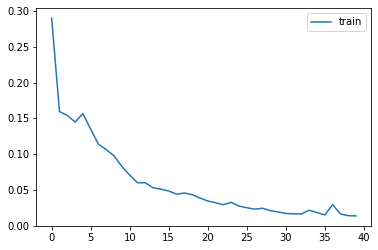

3400/3400 [==============================] - 10s 3ms/step
mean_squared_error[0.04310781772221055, 0.04310781508684158, 0.9529411792755127]


In [103]:
loss = 'mean_squared_error'
model = getLossModel(train_X, train_y, loss)
test_mse = model.evaluate(test_X, test_y, verbose=1)
print(loss + str(test_mse))

# Results

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
[[ 540   79]
 [  81 2700]]
Classification Report
               precision    recall  f1-score   support

Not Depressed       0.87      0.87      0.87       619
    Depressed       0.97      0.97      0.97      2781

     accuracy                           0.95      3400
    macro avg       0.92      0.92      0.92      3400
 weighted avg       0.95      0.95      0.95      3400



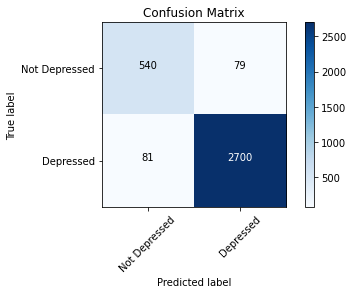

In [106]:
num_of_test_samples = 3400
batch_size = 120
y_pred = model.predict_classes(test_X, num_of_test_samples // batch_size+1)
print('Confusion Matrix')
cm = confusion_matrix(test_y, y_pred)
target_names = ['Not Depressed', 'Depressed']
plot_confusion_matrix(cm, classes=target_names, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_y, y_pred, target_names=target_names))

# Model 2

In [134]:
def createLSTM2(X_data, loss):
    model = Sequential()

    # layer 1: LSTM
    model.add(LSTM(768, input_shape=(X_data.shape[1], X_data.shape[2])
                   , return_sequences=False))
    
    # output
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer='adam', metrics=['binary_crossentropy', 'accuracy'])
    return model

In [135]:
def getLossModel2(train_X, train_y, loss):
    model = createLSTM2(train_X, loss)
    # fit network
    history = model.fit(train_X, train_y, epochs=40, batch_size=120, validation_data=(val_X, val_y))

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()

    return model

Train on 3551 samples, validate on 1673 samples
Epoch 1/40
3551/3551 [==============================] - 25s 7ms/step - loss: 0.4966 - binary_crossentropy: 0.4966 - accuracy: 0.7972 - val_loss: 0.4633 - val_binary_crossentropy: 0.4633 - val_accuracy: 0.8183
Epoch 2/40
3551/3551 [==============================] - 27s 7ms/step - loss: 0.4676 - binary_crossentropy: 0.4676 - accuracy: 0.8178 - val_loss: 0.4692 - val_binary_crossentropy: 0.4692 - val_accuracy: 0.8183
Epoch 3/40
3551/3551 [==============================] - 27s 8ms/step - loss: 0.4598 - binary_crossentropy: 0.4598 - accuracy: 0.8184 - val_loss: 0.4356 - val_binary_crossentropy: 0.4356 - val_accuracy: 0.8183
Epoch 4/40
3551/3551 [==============================] - 27s 8ms/step - loss: 0.3940 - binary_crossentropy: 0.3940 - accuracy: 0.8234 - val_loss: 0.3657 - val_binary_crossentropy: 0.3657 - val_accuracy: 0.8201
Epoch 5/40
3551/3551 [==============================] - 28s 8ms/step - loss: 0.3595 - binary_crossentropy: 0.3595 - 

Epoch 40/40
3551/3551 [==============================] - 29s 8ms/step - loss: 0.0019 - binary_crossentropy: 0.0019 - accuracy: 0.9997 - val_loss: 0.0030 - val_binary_crossentropy: 0.0030 - val_accuracy: 0.9982


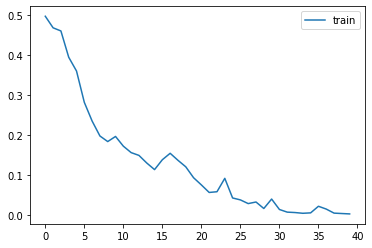

3400/3400 [==============================] - 12s 3ms/step
binary_crossentropy[0.28128440806833915, 0.2812844514846802, 0.9529411792755127]


In [136]:
loss = 'binary_crossentropy'
model = getLossModel2(train_X, train_y, loss)
test_mse = model.evaluate(test_X, test_y, verbose=1)
print(loss + str(test_mse))

Confusion Matrix
[[ 572   47]
 [ 113 2668]]
Classification Report
               precision    recall  f1-score   support

Not Depressed       0.84      0.92      0.88       619
    Depressed       0.98      0.96      0.97      2781

     accuracy                           0.95      3400
    macro avg       0.91      0.94      0.92      3400
 weighted avg       0.96      0.95      0.95      3400



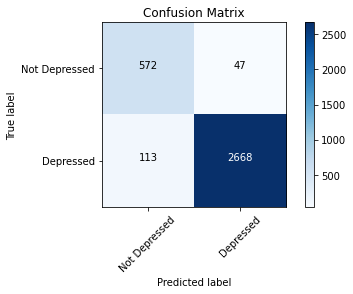

In [137]:
num_of_test_samples = 3400
batch_size = 120
y_pred = model.predict_classes(test_X, num_of_test_samples // batch_size+1)
print('Confusion Matrix')
cm = confusion_matrix(test_y, y_pred)
target_names = ['Not Depressed', 'Depressed']
plot_confusion_matrix(cm, classes=target_names, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_y, y_pred, target_names=target_names))

# Test Model 1 & 2 on Historical Data

## Remove Depressed Post

In [24]:
train_Xh = train_X[:, 1:]
val_Xh = val_X[:, 1:]
test_Xh = test_X[:, 1:]
train_Xh.shape

(3551, 29, 768)

## Test Historical Data on Model 1

In [25]:
def createLSTM(X_data, loss):
    model = Sequential()

    # layer 1: LSTM
    model.add(LSTM(400, input_shape=(X_data.shape[1], X_data.shape[2])
                   , return_sequences=True))
    model.add(Dropout(0.2))
    # layer 2: LSTM
    model.add(LSTM(150, return_sequences=False))
    model.add(Dropout(0.2))

    # output
    model.add(Dense(1))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
def getLossModel(train_Xh, train_y, loss):
    model = createLSTM(train_Xh, loss)
    # fit network
    history = model.fit(train_Xh, train_y, epochs=40, batch_size=120, validation_data=(val_Xh, val_y))

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()

    return model

Train on 3551 samples, validate on 1673 samples
Epoch 1/40
3551/3551 [==============================] - 15s 4ms/step - loss: 0.3264 - accuracy: 0.6908 - val_loss: 0.1566 - val_accuracy: 0.8183
Epoch 2/40
3551/3551 [==============================] - 14s 4ms/step - loss: 0.1600 - accuracy: 0.8144 - val_loss: 0.1466 - val_accuracy: 0.8183
Epoch 3/40
3551/3551 [==============================] - 15s 4ms/step - loss: 0.1557 - accuracy: 0.8164 - val_loss: 0.1450 - val_accuracy: 0.8183
Epoch 4/40
3551/3551 [==============================] - 15s 4ms/step - loss: 0.1426 - accuracy: 0.8158 - val_loss: 0.1283 - val_accuracy: 0.8350
Epoch 5/40
3551/3551 [==============================] - 16s 4ms/step - loss: 0.1375 - accuracy: 0.8161 - val_loss: 0.1224 - val_accuracy: 0.8279
Epoch 6/40
3551/3551 [==============================] - 16s 5ms/step - loss: 0.1242 - accuracy: 0.8375 - val_loss: 0.1176 - val_accuracy: 0.8482
Epoch 7/40
3551/3551 [==============================] - 16s 4ms/step - loss: 0.119

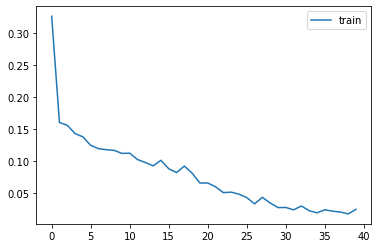

3400/3400 [==============================] - 9s 3ms/step
mean_squared_error[0.07852765586446313, 0.9176470637321472]


In [27]:
loss = 'mean_squared_error'
model = getLossModel(train_Xh, train_y, loss)
test_mse = model.evaluate(test_Xh, test_y, verbose=1)
print(loss + str(test_mse))

Confusion Matrix
[[ 424  195]
 [  84 2697]]
Classification Report
               precision    recall  f1-score   support

Not Depressed       0.83      0.68      0.75       619
    Depressed       0.93      0.97      0.95      2781

     accuracy                           0.92      3400
    macro avg       0.88      0.83      0.85      3400
 weighted avg       0.91      0.92      0.91      3400



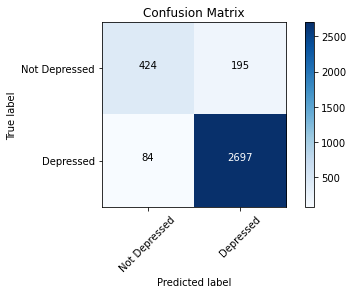

In [28]:
num_of_test_samples = 3400
batch_size = 120
y_pred = model.predict_classes(test_Xh, num_of_test_samples // batch_size+1)
print('Confusion Matrix')
cm = confusion_matrix(test_y, y_pred)
target_names = ['Not Depressed', 'Depressed']
plot_confusion_matrix(cm, classes=target_names, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_y, y_pred, target_names=target_names))

## Test Historical Data on Model 2

In [32]:
def createLSTM2(X_data, loss):
    model = Sequential()

    # layer 1: LSTM
    model.add(LSTM(768, input_shape=(X_data.shape[1], X_data.shape[2])
                   , return_sequences=False))
    
    # output
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

In [33]:
def getLossModel2(train_Xh, train_y, loss):
    model = createLSTM2(train_Xh, loss)
    # fit network
    history = model.fit(train_Xh, train_y, epochs=40, batch_size=120, validation_data=(val_Xh, val_y))

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()

    return model

Train on 3551 samples, validate on 1673 samples
Epoch 1/40
3551/3551 [==============================] - 24s 7ms/step - loss: 0.4976 - accuracy: 0.8167 - val_loss: 0.4633 - val_accuracy: 0.8183
Epoch 2/40
3551/3551 [==============================] - 25s 7ms/step - loss: 0.4548 - accuracy: 0.8181 - val_loss: 0.4171 - val_accuracy: 0.8129
Epoch 3/40
3551/3551 [==============================] - 26s 7ms/step - loss: 0.4644 - accuracy: 0.8181 - val_loss: 0.4438 - val_accuracy: 0.8183
Epoch 4/40
3551/3551 [==============================] - 26s 7ms/step - loss: 0.4224 - accuracy: 0.8217 - val_loss: 0.4137 - val_accuracy: 0.8183
Epoch 5/40
3551/3551 [==============================] - 27s 8ms/step - loss: 0.3907 - accuracy: 0.8279 - val_loss: 0.4951 - val_accuracy: 0.7370
Epoch 6/40
3551/3551 [==============================] - 27s 8ms/step - loss: 0.3942 - accuracy: 0.8299 - val_loss: 0.3788 - val_accuracy: 0.8458
Epoch 7/40
3551/3551 [==============================] - 27s 8ms/step - loss: 0.363

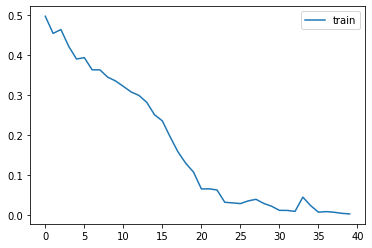

3400/3400 [==============================] - 9s 3ms/step
binary_crossentropy[0.4936375032781678, 0.9244117736816406]


In [34]:
loss = 'binary_crossentropy'
model = getLossModel2(train_Xh, train_y, loss)
test_mse = model.evaluate(test_Xh, test_y, verbose=1)
print(loss + str(test_mse))

Confusion Matrix
[[ 454  165]
 [  92 2689]]
Classification Report
               precision    recall  f1-score   support

Not Depressed       0.83      0.73      0.78       619
    Depressed       0.94      0.97      0.95      2781

     accuracy                           0.92      3400
    macro avg       0.89      0.85      0.87      3400
 weighted avg       0.92      0.92      0.92      3400



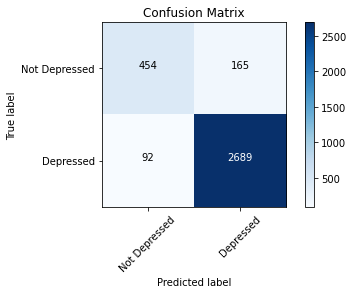

In [35]:
num_of_test_samples = 3400
batch_size = 120
y_pred = model.predict_classes(test_Xh, num_of_test_samples // batch_size+1)
print('Confusion Matrix')
cm = confusion_matrix(test_y, y_pred)
target_names = ['Not Depressed', 'Depressed']
plot_confusion_matrix(cm, classes=target_names, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_y, y_pred, target_names=target_names))

# Test Model 1 & 2 using first post
For depressed users, the first post is the depressed post. For non dereseed users, it is their first post collected.

## Remove Historical Posts

In [37]:
train_Xd = train_X[:, 0]
train_Xd = np.reshape(train_Xd, (train_Xd.shape[0], 1, train_Xd.shape[1]))
val_Xd = val_X[:, 0]
val_Xd = np.reshape(val_Xd, (val_Xd.shape[0], 1, val_Xd.shape[1]))
test_Xd = test_X[:, 0]
test_Xd = np.reshape(test_Xd, (test_Xd.shape[0], 1, test_Xd.shape[1]))
train_Xd.shape

(3551, 1, 768)

## Test Model 1 on first post only

In [38]:
def createLSTM(X_data, loss):
    model = Sequential()

    # layer 1: LSTM
    model.add(LSTM(400, input_shape=(X_data.shape[1], X_data.shape[2])
                   , return_sequences=True))
    model.add(Dropout(0.2))
    # layer 2: LSTM
    model.add(LSTM(150, return_sequences=False))
    model.add(Dropout(0.2))

    # output
    model.add(Dense(1))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

In [39]:
def getLossModel(train_Xd, train_y, loss):
    model = createLSTM(train_Xd, loss)
    # fit network
    history = model.fit(train_Xd, train_y, epochs=40, batch_size=120, validation_data=(val_Xd, val_y))

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()

    return model

Train on 3551 samples, validate on 1673 samples
Epoch 1/40
3551/3551 [==============================] - 2s 429us/step - loss: 0.1762 - accuracy: 0.7778 - val_loss: 0.0929 - val_accuracy: 0.8685
Epoch 2/40
3551/3551 [==============================] - 1s 275us/step - loss: 0.0889 - accuracy: 0.8826 - val_loss: 0.0766 - val_accuracy: 0.9068
Epoch 3/40
3551/3551 [==============================] - 1s 277us/step - loss: 0.0771 - accuracy: 0.9062 - val_loss: 0.0708 - val_accuracy: 0.8990
Epoch 4/40
3551/3551 [==============================] - 1s 280us/step - loss: 0.0724 - accuracy: 0.9079 - val_loss: 0.0665 - val_accuracy: 0.9074
Epoch 5/40
3551/3551 [==============================] - 1s 295us/step - loss: 0.0666 - accuracy: 0.9161 - val_loss: 0.0640 - val_accuracy: 0.9085
Epoch 6/40
3551/3551 [==============================] - 1s 283us/step - loss: 0.0635 - accuracy: 0.9206 - val_loss: 0.0580 - val_accuracy: 0.9217
Epoch 7/40
3551/3551 [==============================] - 1s 282us/step - loss

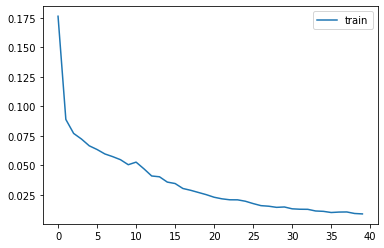

3400/3400 [==============================] - 0s 127us/step
mean_squared_error[0.043500202862436284, 0.9470587968826294]


In [40]:
loss = 'mean_squared_error'
model = getLossModel(train_Xd, train_y, loss)
test_mse = model.evaluate(test_Xd, test_y, verbose=1)
print(loss + str(test_mse))

Confusion Matrix
[[ 532   87]
 [  88 2693]]
Classification Report
               precision    recall  f1-score   support

Not Depressed       0.86      0.86      0.86       619
    Depressed       0.97      0.97      0.97      2781

     accuracy                           0.95      3400
    macro avg       0.91      0.91      0.91      3400
 weighted avg       0.95      0.95      0.95      3400



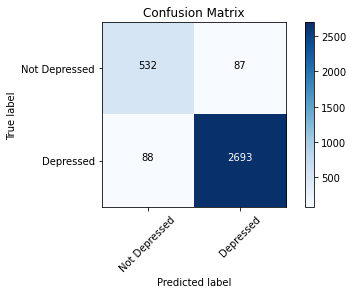

In [41]:
num_of_test_samples = 3400
batch_size = 120
y_pred = model.predict_classes(test_Xd, num_of_test_samples // batch_size+1)
print('Confusion Matrix')
cm = confusion_matrix(test_y, y_pred)
target_names = ['Not Depressed', 'Depressed']
plot_confusion_matrix(cm, classes=target_names, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_y, y_pred, target_names=target_names))

## Test Model 2 on first post only

In [42]:
def createLSTM2(X_data, loss):
    model = Sequential()

    # layer 1: LSTM
    model.add(LSTM(768, input_shape=(X_data.shape[1], X_data.shape[2])
                   , return_sequences=False))
    
    # output
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

In [43]:
def getLossModel2(train_Xd, train_y, loss):
    model = createLSTM2(train_Xd, loss)
    # fit network
    history = model.fit(train_Xd, train_y, epochs=40, batch_size=120, validation_data=(val_Xd, val_y))

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()

    return model

Train on 3551 samples, validate on 1673 samples
Epoch 1/40
3551/3551 [==============================] - 2s 645us/step - loss: 0.3450 - accuracy: 0.8231 - val_loss: 0.2452 - val_accuracy: 0.8864
Epoch 2/40
3551/3551 [==============================] - 2s 540us/step - loss: 0.2270 - accuracy: 0.8997 - val_loss: 0.2238 - val_accuracy: 0.9103
Epoch 3/40
3551/3551 [==============================] - 2s 556us/step - loss: 0.2117 - accuracy: 0.9090 - val_loss: 0.2006 - val_accuracy: 0.9187
Epoch 4/40
3551/3551 [==============================] - 2s 533us/step - loss: 0.2047 - accuracy: 0.9113 - val_loss: 0.1883 - val_accuracy: 0.9235
Epoch 5/40
3551/3551 [==============================] - 2s 541us/step - loss: 0.1905 - accuracy: 0.9203 - val_loss: 0.1777 - val_accuracy: 0.9265
Epoch 6/40
3551/3551 [==============================] - 2s 531us/step - loss: 0.1787 - accuracy: 0.9254 - val_loss: 0.1673 - val_accuracy: 0.9337
Epoch 7/40
3551/3551 [==============================] - 2s 584us/step - loss

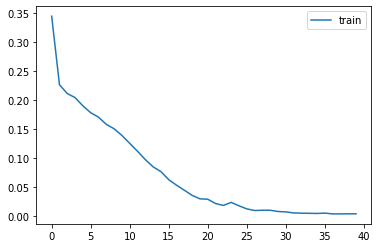

3400/3400 [==============================] - 0s 109us/step
binary_crossentropy[0.25497932332759615, 0.9479411840438843]


In [44]:
loss = 'binary_crossentropy'
model = getLossModel2(train_Xd, train_y, loss)
test_mse = model.evaluate(test_Xd, test_y, verbose=1)
print(loss + str(test_mse))

Confusion Matrix
[[ 550   69]
 [ 108 2673]]
Classification Report
               precision    recall  f1-score   support

Not Depressed       0.84      0.89      0.86       619
    Depressed       0.97      0.96      0.97      2781

     accuracy                           0.95      3400
    macro avg       0.91      0.92      0.91      3400
 weighted avg       0.95      0.95      0.95      3400



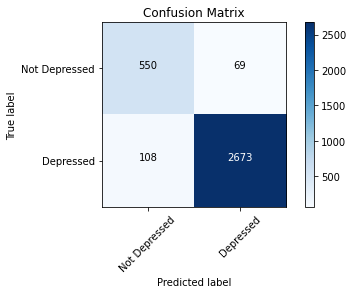

In [45]:
num_of_test_samples = 3400
batch_size = 120
y_pred = model.predict_classes(test_Xd, num_of_test_samples // batch_size+1)
print('Confusion Matrix')
cm = confusion_matrix(test_y, y_pred)
target_names = ['Not Depressed', 'Depressed']
plot_confusion_matrix(cm, classes=target_names, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_y, y_pred, target_names=target_names))